# Final Project

The final project is related to the Kaggle competition - Dog Breed Identification (https://www.kaggle.com/c/dog-breed-identification). The objective was to classify the dog's breed based on the provided images for the competition. There were 120 breeds in total. The evaluation metric is Multi Class Log Loss (https://www.kaggle.com/wiki/MultiClassLogLoss).

The opportunity was taken to partake in the classfication competition, as well as experiment with Generative Models on the training data.

The Inception V3 model was used in for the Classification exercise, and an Autoencoder model was built and trained for the Generative model exercise.



# Outline

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [Final Project Sypnosis](#final-project-synopsis)
- [Part One - Transfer Learning and Classification With Inception](#part-one-classification)
    - [Preparing the Data](#part-one-preparing-the-data)
    - [Preparing the Model](#part-one-preparing-the-model)
    - [Training the Model](#part-one-training-the-model)
    - [Model Performance on Kaggle](#part-one-model-performance)

- [Part Two - Explore the Latent Manifolds](#part-two-latent)
    - [Preparing the Data](#part-two-preparing-the-data)
    - [Latent Manifold Visualisations in TSNE](#part-two-visual1)
    - [Visualisations of Images vs. Latent Manifold](#part-two-visual2)

- [Part Three - Variational Encoder](#part-three-vae)
    - [Preparing the Data](#part-three-preparing-the-data)
    - [Preparing the Model](#part-three-preparing-the-model)
    - [Training the Model](#part-three-training-the-model)
    - [Explore Style Transfer](#part-three-apply1)
    - [Explore Model's Effectiveness Reconstructing Dog Images](#part-three-apply2)

<!-- /MarkdownTOC -->


In [2]:
import sys
# Now get necessary libraries
try:
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
except ImportError:
    print('You are missing some packages! ' \
          'We will try installing them before continuing!')
    !pip install "numpy>=1.11.0" "matplotlib>=1.5.1" "scikit-image>=0.11.3" "scikit-learn>=0.17" "scipy>=0.17.0"
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    from skimage.transform import resize
    from skimage import data
    from scipy.misc import imresize
    import IPython.display as ipyd
    print('Done!')

# Import Tensorflow
try:
    import tensorflow as tf
except ImportError:
    print("You do not have tensorflow installed!")
    print("Follow the instructions on the following link")
    print("to install tensorflow before continuing:")
    print("")
    print("https://github.com/pkmital/CADL#installation-preliminaries")

# This cell includes the provided libraries from the zip file
# and a library for displaying images from ipython, which
# we will use to display the gif
try:
    from libs import utils, gif, datasets, dataset_utils, vae, dft
except ImportError:
    print("Make sure you have started notebook in the same directory" +
          " as the provided zip file which includes the 'libs' folder" +
          " and the file 'utils.py' inside of it.  You will NOT be able"
          " to complete this assignment unless you restart jupyter"
          " notebook inside the directory created by extracting"
          " the zip file or cloning the github repo.")

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')

Make sure you have started notebook in the same directory as the provided zip file which includes the 'libs' folder and the file 'utils.py' inside of it.  You will NOT be able to complete this assignment unless you restart jupyter notebook inside the directory created by extracting the zip file or cloning the github repo.


In [3]:
# Bit of formatting because I don't like the default inline code style:
from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 4px;
    color: #c7254e;
    background-color: #f9f2f4;
    border-radius: 4px;
} </style>""")

<a name="final-project-synopsis"></a>
# Final Project Synopsis


<a name="part-one-classification"></a>
# Part One - Transfer Learning and Classification With Inception

<a name="part-one-preparing-the-data"></a>
## Preparing the Data
The following data was downloaded from https://www.kaggle.com/c/dog-breed-identification/data:
<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->
- train.zip - 327,000 training data dog images.
- test.zip - 10,157 test data dog images.
- label.csv.zip - CSV file containing the 120 dog breed labels.

The images from the train.zip and test.zip files were extracted to the train and test folders respectively.

The process_images.py script moves the train dog images into sub-directories named based on their breed. The train directory was used as the parent directory. This is to accommodate the retrain.py script, which expects the images to be stored in directories named as per their classifications.

For example, if train/001513dfcb2ffafc82cccf4d8bbaba97.jpg contained an image of a dingo, the file would be moved to train/dingo/001513dfcb2ffafc82cccf4d8bbaba97.jpg.

In [ ]:
%run process_images.py

<a name="part-one-preparing-the-model"></a>
## Preparing the Model

The Inception V3 model was used for this exercise. A layer (final_training_ops) was added after the pool_3 layer to accomodate the 120 dog breed classes that are unavailable on the standard Inception model:
<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->
- Input to final Layer: [None, 2048]
- Weights: [2048, 120]
- Biases: [120]
- Softmax Layer: [120]
- Cost function: Reduce mean of softmax_cross_entropy_with_logits
- Optimizer: Gradient Descent

Below is a graphical representation of the final layer

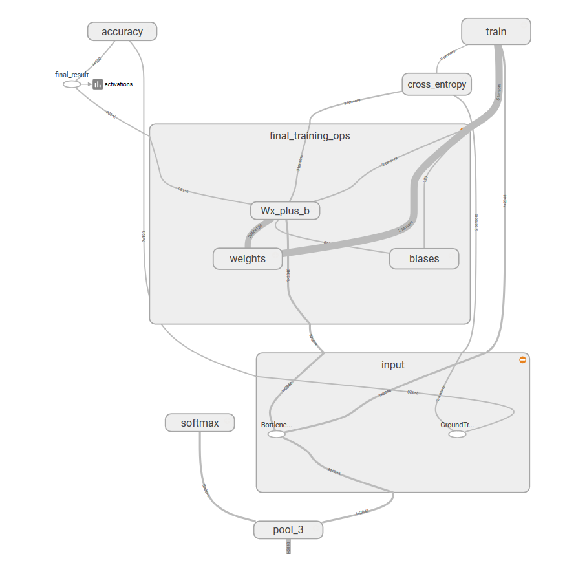

In [18]:
final_training_ops = plt.imread("final_training_ops.png")
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
plt.grid('off'), plt.axis('off')
plt.imshow(final_training_ops)

<a name="part-one-training-the-model"></a>
## Training the Model
Transfer learning is a technique that shortcuts a lot of this work by taking a fully-trained model for a set of categories like ImageNet, and retrains from the existing weights for new classes. In this example we'll be retraining the final layer from scratch, while leaving all the others untouched.

'Bottleneck' is an informal term used for the layer just before the final output layer that actually does the classification. This penultimate layer has been trained to output a set of values that's good enough for the classifier to use to distinguish between all the classes it's been asked to recognize. That means it has to be a meaningful and compact summary of the images, since it has to contain enough information for the classifier to make a good choice in a very small set of values. The reason our final layer retraining can work on new classes is that it turns out the kind of information needed to distinguish between all the 1,000 classes in ImageNet is often also useful to distinguish between new kinds of objects.

For the training, the bottleneck data associated to the images is saved in text files. The script saves the Tensorboard output as well as the model's graph file at the end of training. For further information with regards to bottlenecks and Tensorboard, go to https://www.tensorflow.org/tutorials/image_retraining#bottlenecks and https://www.tensorflow.org/get_started/summaries_and_tensorboard respectively.

The following parameters were defined for the script:
<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->
- Bottleneck/Latent Manifold directory: model_out/bottlenecks 
- Training epoches: 4000 
- Model directory: model_out/models/ 
- Tensorboard summary directory: model_out/training_summaries/inception_v3 
- Tensorflow output graph: model_out/retrained_graph.pb
- Output labels: model_out/retrained_labels.txt 
- Training image data directory: train

In [ ]:
%run retrain.py --bottleneck_dir=model_out/bottlenecks --how_many_training_steps=4000 --model_dir=model_out/models/ --summaries_dir=model_out/training_summaries/inception_v3 --output_graph=model_out/retrained_graph.pb --output_labels=model_out/retrained_labels.txt --image_dir=train

<a name="part-one-model-performance"></a>
## Model Performance on Kaggle

<a name="part-one-model-performance-train"></a>
### Model Performance on Training Data
The trained model achieved a cross entropy loss of 0.3437 for the training set and 0.4686 for the validation set.
Prediction accuracy rates were approximately 91% for the training set and 90% for the validation set.

(<matplotlib.image.AxesImage at 0x26a227d8518>,
 None,
 (-0.5, 982.5, 616.5, -0.5))

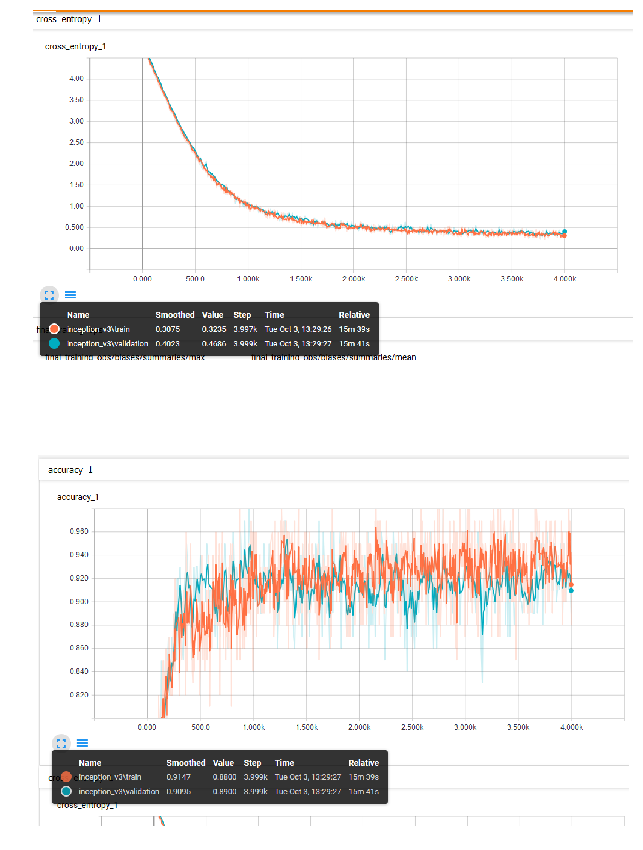

In [20]:
cross_entropy_image = plt.imread("cross_entropy_1.png")
accuracy_image = plt.imread("accuracy_1.png")
fig, axs = plt.subplots(2, 1, figsize=(20, 15))
axs[0].imshow(cross_entropy_image), axs[0].grid('off'), axs[0].axis('off')
axs[1].imshow(accuracy_image), axs[1].grid('off'), axs[1].axis('off')

<a name="part-one-model-performance-test"></a>
### Model Performance on Testing Data

For the 10157 images in the test set, the below script predicts a probability for each of the 120 breeds and writes it to an output file (submission.csv by default). The output file contains a header and has the following format:

    id,affenpinscher,afghan_hound,..,yorkshire_terrier
    000621fb3cbb32d8935728e48679680e,0.0083,0.0,...,0.0083

The following parameters were defined for the script:
<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->
- Trained graph: model_out/retrained_graph.pb 
- Test image directory: test 
- Classification Labels: model_out/retrained_labels.txt

In [ ]:
%run label_image.py --graph=model_out/retrained_graph.pb --image_dir=test --labels=model_out/retrained_labels.txt

The file was submitted to kaggle, and the model achieved a Multi Log Loss score of 0.58106

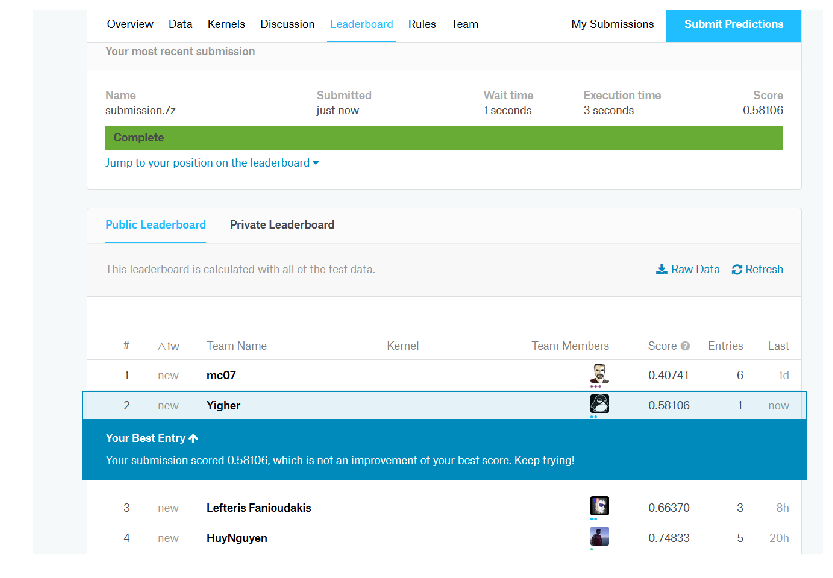

In [21]:
final_training_ops = plt.imread("test_result.png")
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
plt.grid('off'), plt.axis('off')
plt.imshow(final_training_ops)

<a name="part-two-latent"></a>
# Part Two - Explore the Weight Activations & Latent Manifolds


<a name="part-three-preparing-the-data"></a>
## Explore the Weight Activations

Let's load the model saved in model_out/retrained_graph.pb

In [3]:
from tensorflow.python.framework import ops
ops.reset_default_graph()

filename='model_out/retrained_graph.pb'

with tf.gfile.FastGFile(filename, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')

List the layer names

In [4]:
g = tf.get_default_graph()
names = [op.name for op in g.get_operations()]
names

['DecodeJpeg/contents',
 'DecodeJpeg',
 'Cast',
 'ExpandDims/dim',
 'ExpandDims',
 'ResizeBilinear/size',
 'ResizeBilinear',
 'Sub/y',
 'Sub',
 'Mul/y',
 'Mul',
 'conv/conv2d_params',
 'conv/Conv2D',
 'conv/batchnorm/beta',
 'conv/batchnorm/gamma',
 'conv/batchnorm/moving_mean',
 'conv/batchnorm/moving_variance',
 'conv/batchnorm',
 'conv/CheckNumerics',
 'conv/control_dependency',
 'conv',
 'conv_1/conv2d_params',
 'conv_1/Conv2D',
 'conv_1/batchnorm/beta',
 'conv_1/batchnorm/gamma',
 'conv_1/batchnorm/moving_mean',
 'conv_1/batchnorm/moving_variance',
 'conv_1/batchnorm',
 'conv_1/CheckNumerics',
 'conv_1/control_dependency',
 'conv_1',
 'conv_2/conv2d_params',
 'conv_2/Conv2D',
 'conv_2/batchnorm/beta',
 'conv_2/batchnorm/gamma',
 'conv_2/batchnorm/moving_mean',
 'conv_2/batchnorm/moving_variance',
 'conv_2/batchnorm',
 'conv_2/CheckNumerics',
 'conv_2/control_dependency',
 'conv_2',
 'pool/CheckNumerics',
 'pool/control_dependency',
 'pool',
 'conv_3/conv2d_params',
 'conv_3/Conv2D

Let's visualize the network's gradient activation  when backpropagated to the original input image. This is effectively telling us which pixels contribute to the predicted class or given neuron.

['pool:0', 'pool_1:0', 'mixed/tower_2/pool:0', 'mixed_1/tower_2/pool:0', 'mixed_2/tower_2/pool:0', 'mixed_3/pool:0', 'mixed_4/tower_2/pool:0', 'mixed_5/tower_2/pool:0', 'mixed_6/tower_2/pool:0', 'mixed_7/tower_2/pool:0', 'mixed_8/pool:0', 'mixed_9/tower_2/pool:0', 'mixed_10/tower_2/pool:0', 'pool_3:0']


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


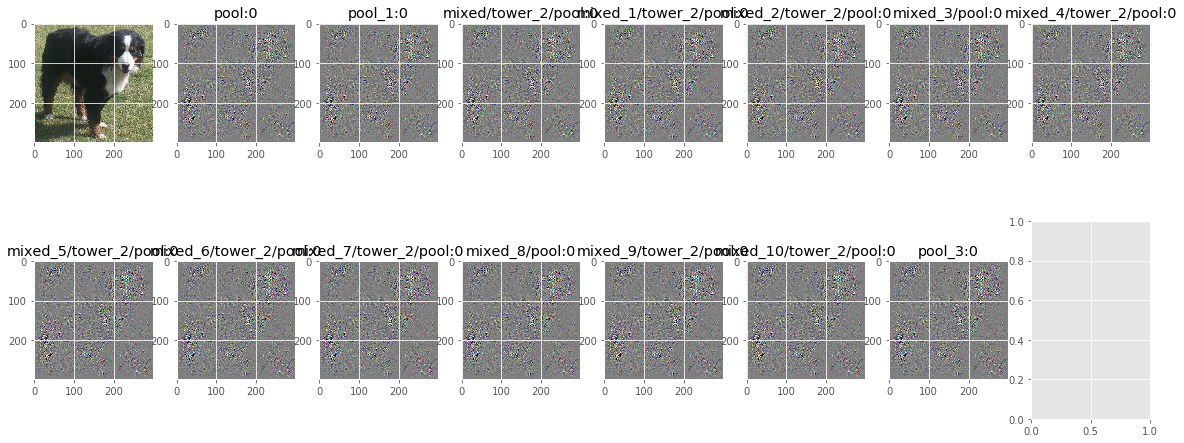

In [13]:
from skimage.transform import resize as imresize
dir_name = 'data/train/bernese_mountain_dog/'
    
def preprocess(img, crop=True, resize=True, dsize=(299, 299)):
    if img.dtype != np.uint8:
        img *= 255.0

    if crop:
        crop = np.min(img.shape[:2])
        r = (img.shape[0] - crop) // 2
        c = (img.shape[1] - crop) // 2
        cropped = img[r: r + crop, c: c + crop]
    else:
        cropped = img

    if resize:
        rsz = imresize(cropped, dsize, preserve_range=True)
    else:
        rsz = cropped

    if rsz.ndim == 2:
        rsz = rsz[..., np.newaxis]

    rsz = rsz.astype(np.float32)
    # subtract imagenet mean
    return (rsz - 117)

def deprocess(img):
    return np.clip(img + 117, 0, 255).astype(np.uint8)

def plot_gradient(img, x, feature, g, device='/cpu:0'):
    """Let's visualize the network's gradient activation
    when backpropagated to the original input image.  This
    is effectively telling us which pixels contribute to the
    predicted layer, class, or given neuron with the layer"""
    
    # We'll be explicit about the graph and the device
    # by using a context manager:
    with tf.Session(graph=g) as sess, g.device(device):
        saliency = tf.gradients(tf.reduce_mean(feature), x)
        this_res = sess.run(saliency[0], feed_dict={x: img})
        grad = this_res[0] / np.max(np.abs(this_res))
        return grad

features = [name + ':0' for name in names if 'pool' in name.split('/')[-1]]
# Let's print them
print(features)

image_data = plt.imread(os.path.join(dir_name, os.listdir(dir_name)[10]))
image_data = preprocess(image_data)[np.newaxis]
x = g.get_tensor_by_name('Mul' + ':0')
 
rows = 2
columns = (len(features)+2) // rows
fig, axs = plt.subplots(rows, columns, figsize=(20, 8))
axs[0, 0].imshow(deprocess(image_data[0]))

for idx, poolname in enumerate(features):
    pool_i = idx + 1
    if pool_i < columns:
        row_idx = 0
        col_idx = pool_i
    else:
        row_idx = 1
        col_idx = pool_i - columns
    grad = plot_gradient(image_data, x, g.get_tensor_by_name(features[i]), g)
    axs[row_idx, col_idx].imshow(utils.normalize(grad))
    axs[row_idx, col_idx].set_title(poolname)

<a name="part-two-visual1"></a>
## Latent Manifold Visualisations in TSNE

TSNE is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. The technique can be implemented via Barnes-Hut approximations. For more information on TSNE, go to https://lvdmaaten.github.io/tsne/.

The objective of this section is observe if the dog images can be clustered into groups based on their classifications

Let's first prepare the data from the bottleneck directories. We specify 50 latent manifolds per class of breed in the below code.

In [14]:
from libs.dog_data_dao import DogDataDao
num_limit = 50
dao = DogDataDao(z_dir='model_out/bottlenecks', img_dir='data/train')
# Get label of dog breeds
class_labels = dao.get_z_labels()
class_labels = np.sort(class_labels)
zs_data = None
labels_data = None
zs_idx = None
# Retrieve 50 latent manifolds per class
for class_label in class_labels:
    # for each label of dog breed, get 50 z latent manifolds
    z_idx, z_data = dao.get_z_by_label(class_label, num_limit=num_limit)
    z_idx = np.array(z_idx)
    if zs_idx is None:
        zs_idx = z_idx
    else:
        zs_idx = np.hstack((zs_idx, z_idx))
    if zs_data is None:
        zs_data = z_data
    else:
        zs_data = np.vstack((zs_data, z_data))
    label_data = np.repeat(class_label, z_data.shape[0])
    if labels_data is None:
        labels_data = label_data
    else:
        labels_data = np.hstack((labels_data, label_data))

print("zs_data: ", zs_data.shape)
print("labels_data: ", labels_data.shape)
print("zs_idx: ", zs_idx.shape)

zs_data:  (6000, 2048)
labels_data:  (6000,)
zs_idx:  (6000,)


We will use TSNE to visualise how the dog breeds cluster

In [15]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, verbose=5, perplexity=100, n_iter=1500, n_iter_without_progress=300).fit_transform(zs_data)
print("X_embedded: ", X_embedded.shape)
x_embedded_file = "X_embedded.npz"
np.savez("X_embedded.npz", X_embedded)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 5.026691
[t-SNE] Iteration 25: error = 1.0749642, gradient norm = 0.0096006
[t-SNE] Iteration 50: error = 1.0350922, gradient norm = 0.0072562
[t-SNE] Iteration 75: error = 0.8197545, gradient norm = 0.0024368
[t-SNE] Iteration 100: error = 0.7709059, gradient norm = 0.0020258
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.770906
[t-SNE] Iteration 125: error = 0.6896697, gradient norm = 0.0015052
[t-SNE] Iteration 150: error = 0.6640763, gradient norm = 0.0013673
[t-SNE] It

And now let's plot the TSNE clustered output based on the first two components of the model.

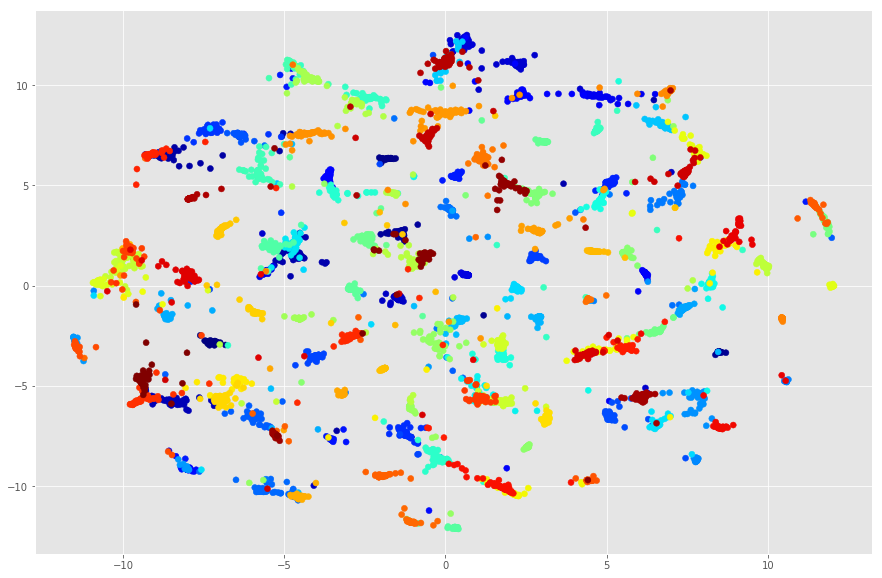

In [17]:
from collections import OrderedDict
x_embedded_file = "X_embedded.npz"
# if os.path.isfile(x_embedded_file):
#     X_embedded = np.load(x_embedded_file)['arr_0']

dog_breeds = list(set(labels_data))
dog_breeds.sort()
dog_breeds
encoder = OrderedDict(zip(dog_breeds, range(len(dog_breeds))))
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[encoder[ld] for ld in labels_data], cmap=plt.get_cmap('jet'))
plt.show()

The plot shows that the images classifications are well seperated into distinct groups. 

<a name="part-two-visual2"></a>
## Visualisations of Images vs. Latent Manifold

The above graph doesn't tell us much from a visualisation perspective. 

We are going to pick out a sample image from each dog breed, and plot it based on the tSNE output components.

zs_idx_sample  (120,)
X_embedded_sample:  (120, 2)


/home/ubuntu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


img_filenames:  120
img_samples:  (120, 299, 299, 3)


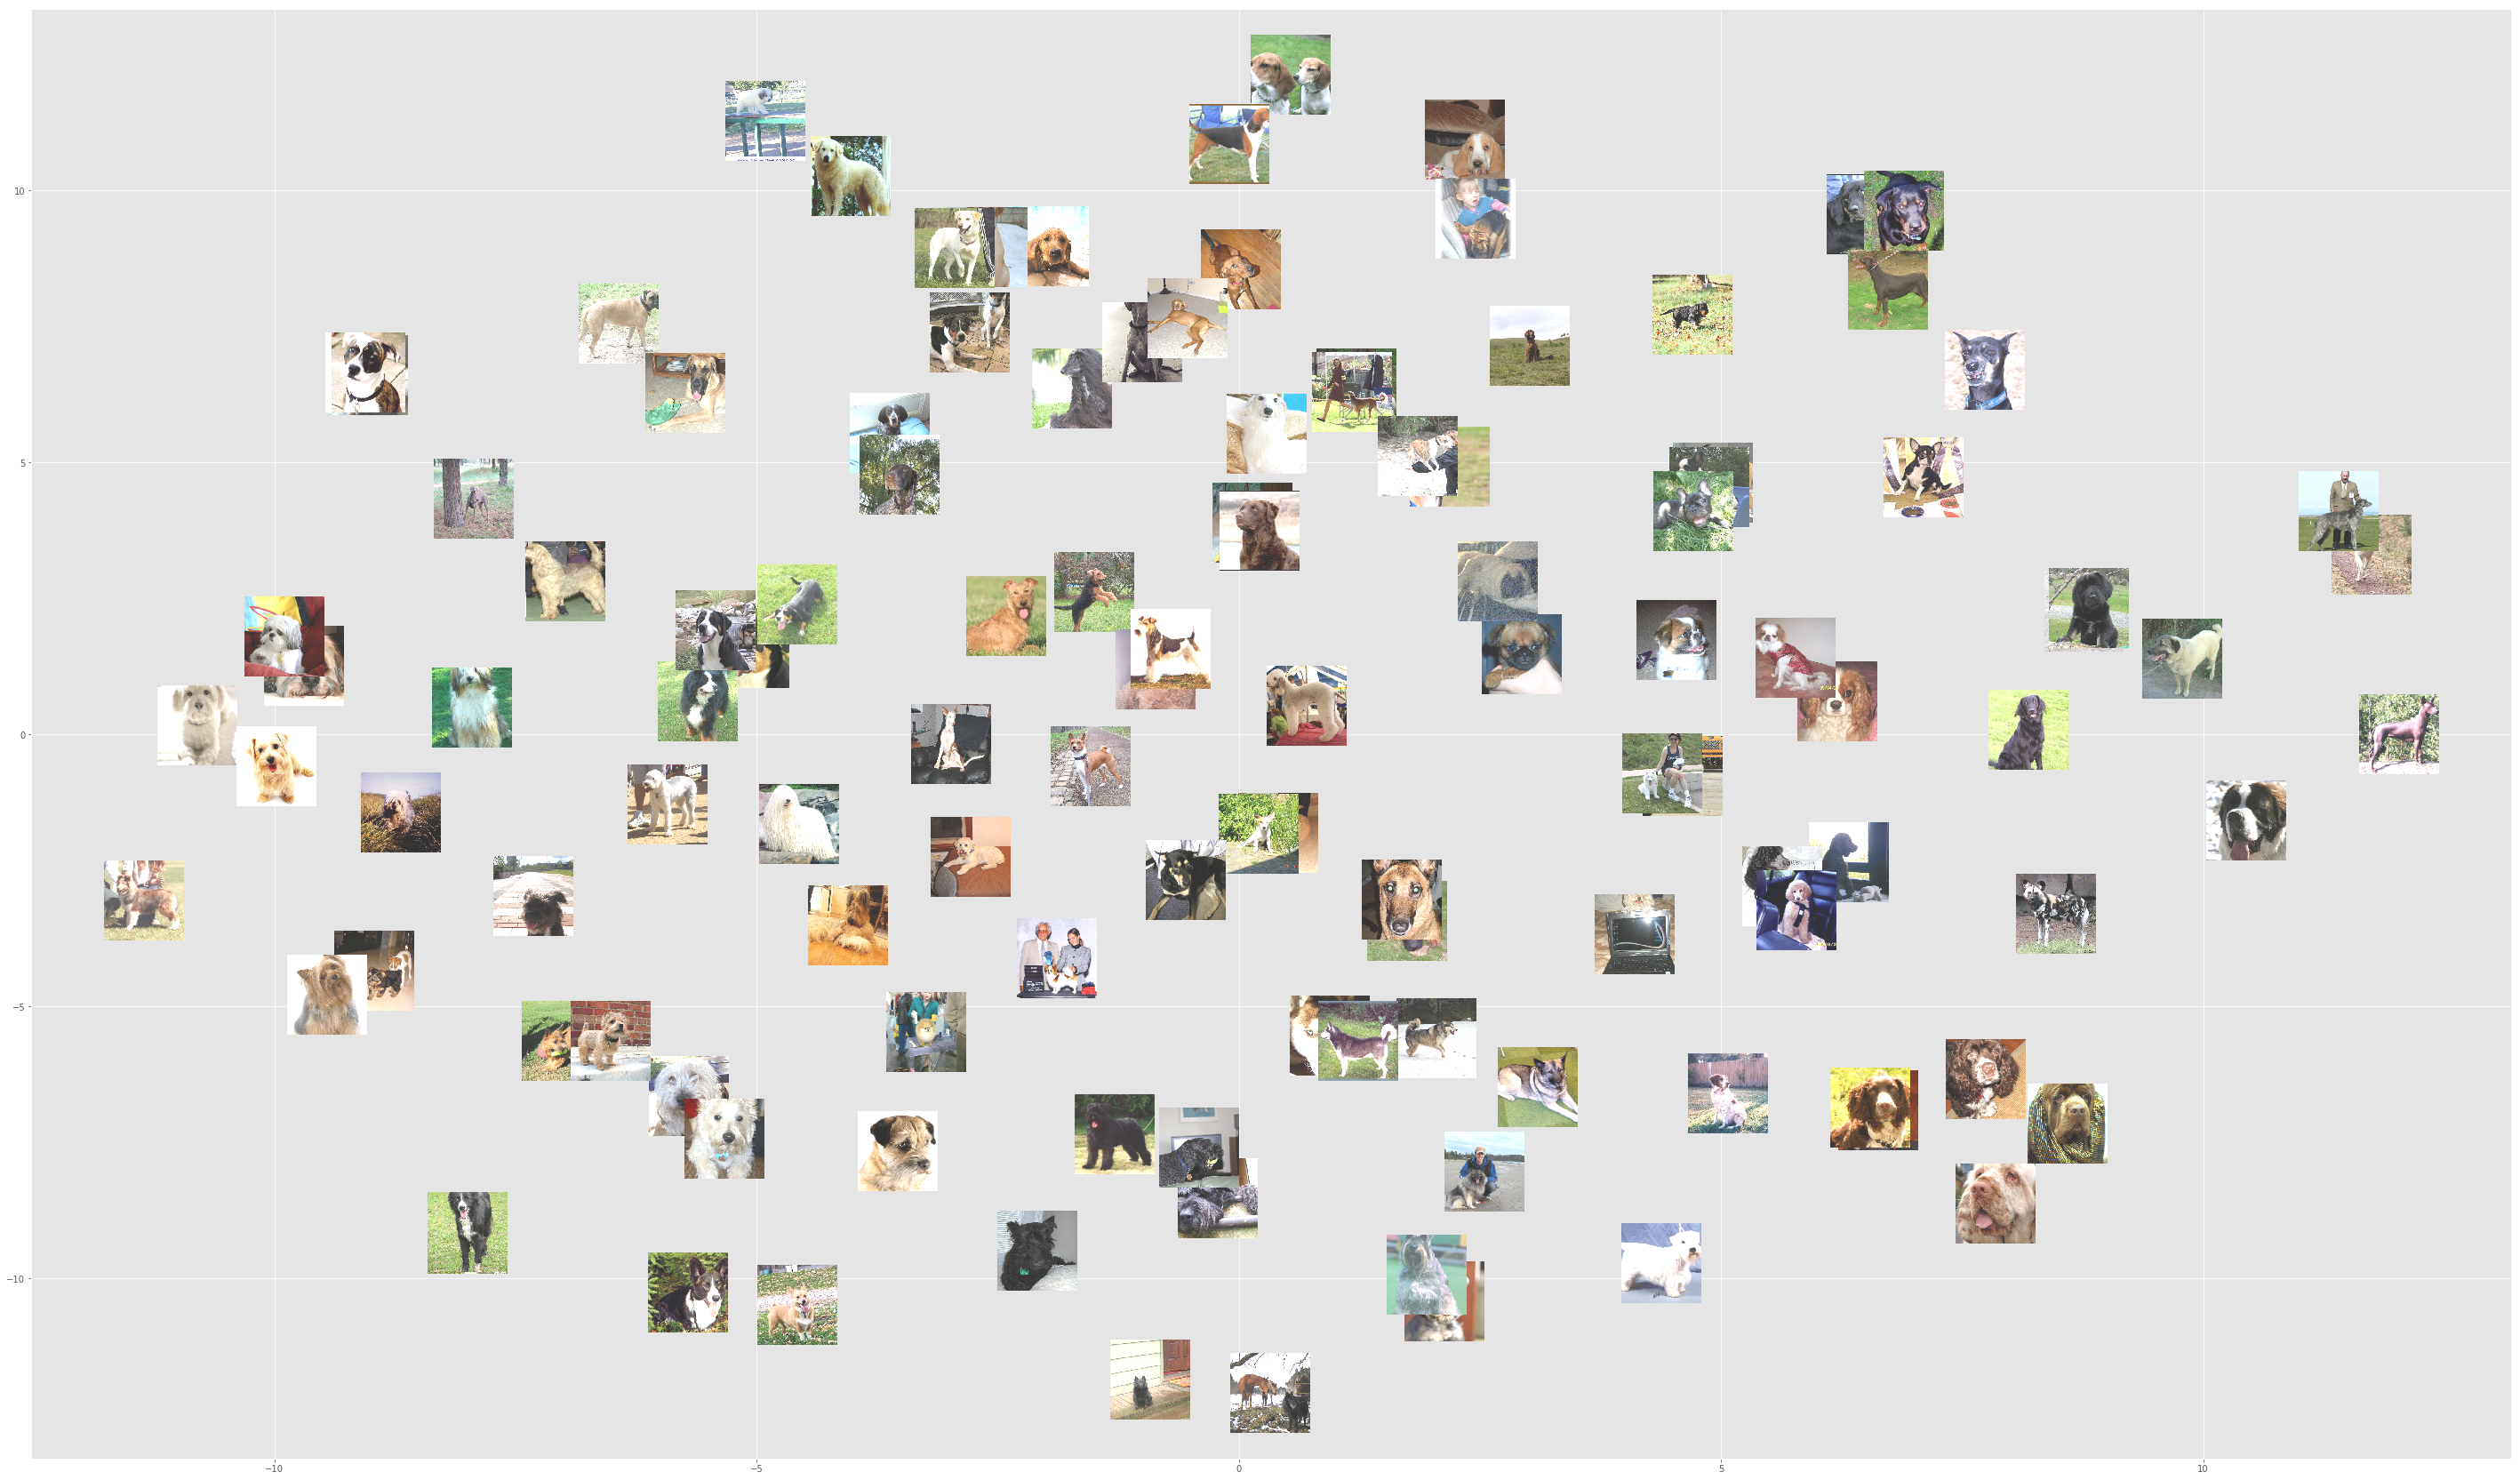

In [18]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from skimage.transform import resize as imresize

def deprocess(img):
    return np.clip(img + 50, 0, 255).astype(np.uint8)

def imscatter(x, y, images, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()

    x, y = np.atleast_1d(x, y)
    artists = []
    i = 0
    for x0, y0 in zip(x, y):
        image = images[i]
        image = deprocess(image)
        im = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
        i += 1
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

# Sample from each group
idx_sample = list(np.arange(0, 5999, 50))
# get the sample zs_idx
zs_idx_sample = zs_idx[idx_sample]
# get the sample embeddings
X_embedded_sample = X_embedded[idx_sample,:]
print("zs_idx_sample ", zs_idx_sample.shape)
print("X_embedded_sample: ", X_embedded_sample.shape)
img_filenames, img_samples = dao.get_img_by_z_filenames(list(zs_idx_sample))
print("img_filenames: ", len(img_filenames))
print("img_samples: ",img_samples.shape)

fig, ax = plt.subplots(1, 1, figsize=(50, 30))
imscatter(X_embedded_sample[:, 0], X_embedded_sample[:, 1], img_samples, ax, 0.3)
# ax.scatter(X_embedded_sample[:, 0], X_embedded_sample[:, 1])
plt.show()
    

The TSNE clustering now makes more sense. The dog images seem to cluster quite well, based on the head, ear, and snout shapes. 

Below is another way to visualise the clustering based on a grid display

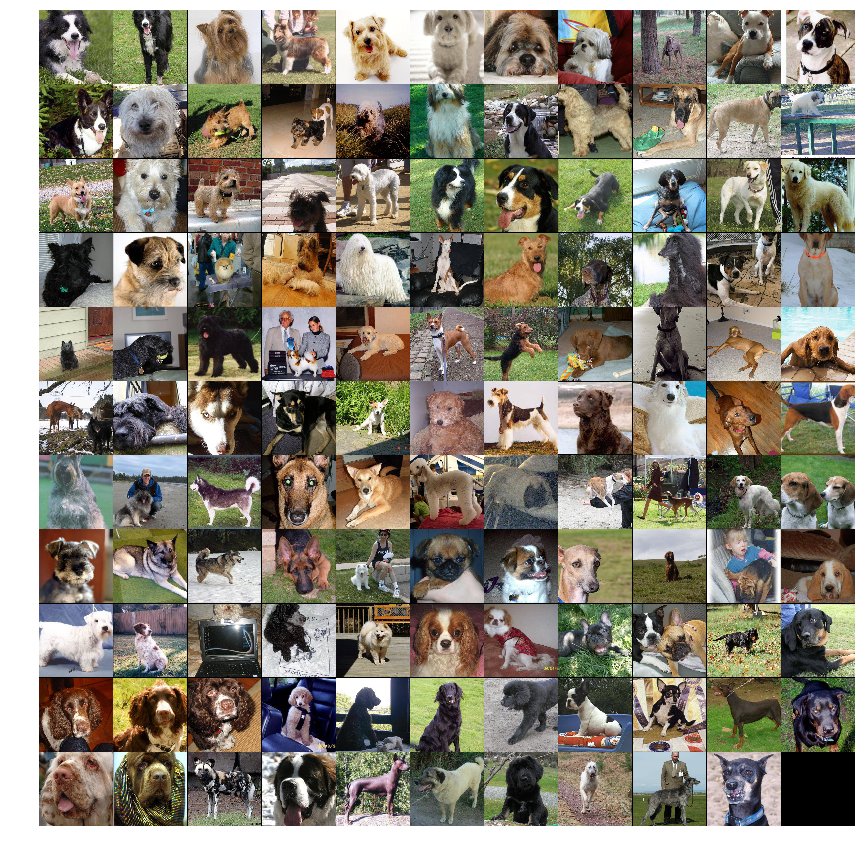

In [21]:
n_images = X_embedded_sample.shape[0]
idxs = np.linspace(np.min(X_embedded_sample) * 2.0, np.max(X_embedded_sample) * 2.0,
                   int(np.ceil(np.sqrt(n_images))))
xs, ys = np.meshgrid(idxs, idxs)
grid = np.dstack((ys, xs)).reshape(-1, 2)[:n_images,:]

from scipy.spatial.distance import cdist
cost = cdist(grid[:, :], X_embedded_sample[:, :], 'sqeuclidean')
from scipy.optimize._hungarian import linear_sum_assignment
indexes = linear_sum_assignment(cost)

examples_sorted = []
for i in indexes[1]:
    examples_sorted.append(img_samples[i])
plt.figure(figsize=(15, 15))
plt.grid('off'), plt.axis('off')
img = utils.montage(np.array(examples_sorted)).astype(np.uint8)
plt.imshow(img,
           interpolation='nearest')
plt.imsave(arr=img, fname='sorted_dogs.png')

Again, the dog images seem to cluster quite well, based on the head, ear, and snout shapes. 

<a name="part-three-vae"></a>
# Part Three - Variational Encoder
<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->
The objective of this section:
- Explore Style Transfer
- Test Variational Encoders' effectiveness in replicating images
<!-- /MarkdownTOC -->
<a name="part-two-preparing-the-data"></a>
## Preparing the Data

The image train folder had been copied to a new directory (train_vae) , and the images resized to (299, 299, 3) using the below script.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize as imresize

def preprocess(img, crop=True, resize=True, dsize=(299, 299)):
    if img.dtype != np.uint8:
        img *= 255.0

    if crop:
        crop = np.min(img.shape[:2])
        r = (img.shape[0] - crop) // 2
        c = (img.shape[1] - crop) // 2
        cropped = img[r: r + crop, c: c + crop]
    else:
        cropped = img

    if resize:
        rsz = imresize(cropped, dsize, preserve_range=True)
    else:
        rsz = cropped

    if rsz.ndim == 2:
        rsz = rsz[..., np.newaxis]

    rsz = rsz.astype(np.uint8)
    # subtract imagenet mean
    return (rsz)

path = "train_vae"
fs = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.jpg'):
            fs.append(os.path.join(root, file))
fs.sort()
for f in fs:
    print("f: ", f)
    img = plt.imread(f)
    img = preprocess(img)
    print("img.shape: ", img.shape)
    plt.imsave(f, img)

In [23]:
import libs.vaegan as vae

vae.test_dog(
        n_epochs=5000,
        filter_sizes=[3, 3, 3, 3],
        n_filters=[100, 100, 100, 100],
        crop_shape=[100, 100, 3])

<a name="part-three-preparing-the-model"></a>
## Preparing the Model

The Autoencoder model configuration is as follows:

Encoder
- Input:  [None, 64, 64, 3]
- Convolutional Layer 1 :  [None, 32, 32, 64]
- Convolutional Layer 2 :  [None, 16, 16, 128]
- Convolutional Layer 3 :  [None, 8, 8, 256]
- Convolutional filter sizes:  [5, 3, 3]
- Variational Layer:  [None, 8, 8, 256]
- Fully Connected Layer: 256
- Latent Samples: 128

Decoder
- Convolutional Layer 1:  [None, 16, 16, 128]
- Convolutional Layer 2:  [None, 32, 32, 64]
- Convolutional Layer 3:  [None, 64, 64, 3]
- Convolutional filter sizes:  [5, 3, 3]



Learning Rate: 0.001

Batch Size: 400

Number of Epochs: 500


In [ ]:
"""DOG VAE"""
import libs.vae as vae
import tensorflow as tf
from libs.datasets import DOG

if __name__ == '__main__':
    F, _ = DOG('data/train_vae')
    vae.train_vae(
        files=F,
        input_shape=[299, 299, 3],
        learning_rate=0.001,
        batch_size=400,
        n_epochs=500,
        crop_shape=[64, 64, 3],
        crop_factor=0.8,
        convolutional=True,
        variational=True,
        n_filters=[64, 128, 256],
        n_hidden=256,
        n_code=128,
        denoising=False,
        dropout=False,
        keep_prob=0.8,
        filter_sizes=[5, 3, 3],
        activation=tf.nn.sigmoid,
        ckpt_name='models/dog_vae.ckpt')

<a name="part-three-training-the-model"></a>
## Training the Model

The model was trained for approximately 5 hours.

In [3]:
with open("logs/dog_vae.log") as f:
    print(f.read())

========= ENCODER =========
input:  [None, 64, 64, 3]
current_input  0 :  [None, 32, 32, 64]
current_input  1 :  [None, 16, 16, 128]
current_input  2 :  [None, 8, 8, 256]
current_input variational:  [None, 8, 8, 256]
shapes:  [[None, 64, 64, 3], [None, 32, 32, 64], [None, 16, 16, 128], [None, 8, 8, 256]]
n_filters:  [64, 128, 256]
filter_sizes:  [5, 3, 3]
========= DECODER =========
shapes:  [[None, 8, 8, 256], [None, 16, 16, 128], [None, 32, 32, 64], [None, 64, 64, 3]]
n_filters:  [256, 128, 64, 3]
filter_sizes:  [5, 3, 3]
shape:  [None, 16, 16, 128]
filter_size:  5
shape:  [None, 32, 32, 64]
filter_size:  3
shape:  [None, 64, 64, 3]
filter_size:  3
1 1456.35
2 1364.12
3 1307.42
4 1283.08
5 1241.73
6 1235.94
7 1213.34
8 1190.62
9 1194.52
10 1162.51
11 1153.08
12 1139.5
13 1144.5
14 1112.71
15 1132.41
16 1122.68
17 1110.61
18 1091.07
19 1131.9
20 1114.36
21 1133.81
22 1117.26
23 1108.31
24 1096.66
25 1089.57
26 1114.6
27 1092.03
28 1086.47
29 1090.95
30 1066.69
31 1079.63
32 1095.87
33

At every 100 batches of images, test images were presented to the model so that a visualisation of its training progress can be obtained from the model. 

Below is a time lapse of the reconstructed images for the training of the model.

In [9]:
ipyd.Image(url='montage_train.gif?i={}'.format(
        np.random.rand()), height=1500, width=1500)

<a name="part-three-apply1"></a>
## Explore Style Transfer

Let's load the pre-trained Autoencoder model.

In [3]:
from tensorflow.python.framework import ops
from libs.vae import VAE
from libs.dataset_utils import create_input_pipeline

ops.reset_default_graph()

input_shape=[299, 299, 3]
learning_rate=0.001
batch_size=400
n_epochs=500
crop_shape=[64, 64, 3]
crop_factor=0.8
convolutional=True
variational=True
n_filters=[64, 128, 256]
n_hidden=256
n_code=128
denoising=True
dropout=False
keep_prob=0.8
filter_sizes=[5, 3, 3]
activation=tf.nn.sigmoid

files = ['data/train/cocker_spaniel/c3b19b9e1ce0c005511fa14e2d9a89ec.jpg']
batch = create_input_pipeline(
    files=files,
    batch_size=batch_size,
    n_epochs=n_epochs,
    crop_shape=crop_shape,
    crop_factor=crop_factor,
    shape=input_shape,
    shuffle=False)

ae = VAE(input_shape=[None] + crop_shape,
             convolutional=convolutional,
             variational=variational,
             n_filters=n_filters,
             n_hidden=n_hidden,
             n_code=n_code,
             dropout=dropout,
             denoising=denoising,
             filter_sizes=filter_sizes,
             activation=activation)


ckpt_name = 'models/dog_vae.ckpt'

# We create a session to use the graph
sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
# This will handle our threaded image pipeline
coord = tf.train.Coordinator()
# Ensure no more changes to graph
# tf.get_default_graph().finalize()
# Start up the queues for handling the image pipeline
threads = tf.train.start_queue_runners(sess=sess, coord=coord)



print("Restoring existing model")
saver.restore(sess, ckpt_name)


Restoring existing model
INFO:tensorflow:Restoring parameters from models/dog_vae.ckpt


Let's run a test image through the model

(<matplotlib.image.AxesImage at 0x1d9748e0b38>, None, (-0.5, 63.5, 63.5, -0.5))

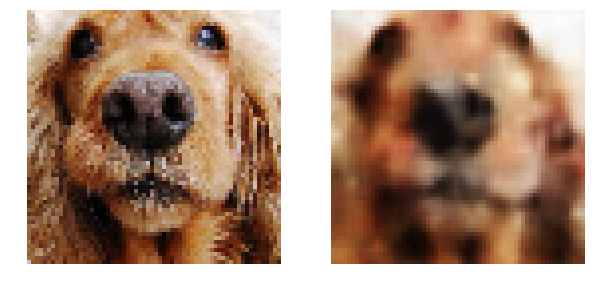

In [4]:
test_image = sess.run(batch) / 255.0
recon = sess.run(
    ae['y'], feed_dict={ae['x']: test_image,
    ae['train']: False,
    ae['keep_prob']: 1.0,
    ae['corrupt_prob']: [0.5]})
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(test_image[0]), axs[0].grid('off'), axs[0].axis('off')
axs[1].imshow(recon[0]), axs[1].grid('off'), axs[1].axis('off')

coord.request_stop()
# Wait until all threads have finished.
coord.join(threads)
# Clean up the session.
sess.close()


The model decoded the image as expected. Let's present all the Saint Bernard images into the model and observe the outcome.

Restoring existing model
INFO:tensorflow:Restoring parameters from models/dog_vae.ckpt


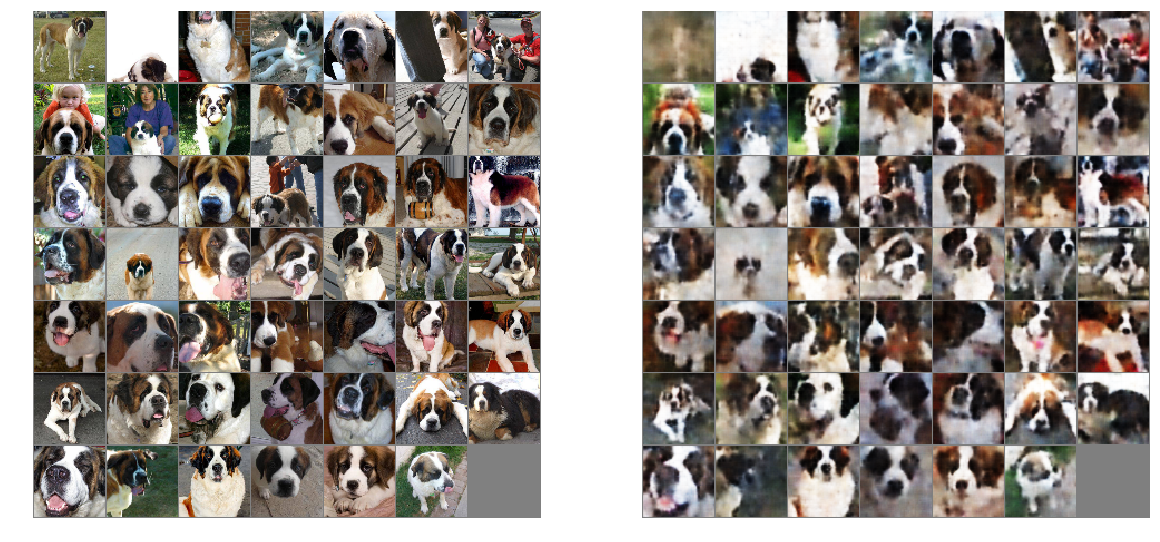

In [4]:
from tensorflow.python.framework import ops
from libs.dataset_utils import create_input_pipeline
from libs.datasets import DOG
from libs.vae import VAE

ops.reset_default_graph()

input_shape=[299, 299, 3]
learning_rate=0.001
batch_size=400
n_epochs=500
crop_shape=[64, 64, 3]
crop_factor=0.8
convolutional=True
variational=True
n_filters=[64, 128, 256]
n_hidden=256
n_code=128
denoising=True
dropout=False
keep_prob=0.8
filter_sizes=[5, 3, 3]
activation=tf.nn.sigmoid

files, _ = DOG('data/train/saint_bernard')
batch = create_input_pipeline(
    files=files,
    batch_size=batch_size,
    n_epochs=n_epochs,
    crop_shape=crop_shape,
    crop_factor=crop_factor,
    shape=input_shape,
    shuffle=False)

ae = VAE(input_shape=[None] + crop_shape,
             convolutional=convolutional,
             variational=variational,
             n_filters=n_filters,
             n_hidden=n_hidden,
             n_code=n_code,
             dropout=dropout,
             denoising=denoising,
             filter_sizes=filter_sizes,
             activation=activation)


ckpt_name = 'models/dog_vae.ckpt'

# We create a session to use the graph
sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
# This will handle our threaded image pipeline
coord = tf.train.Coordinator()
# Ensure no more changes to graph
# tf.get_default_graph().finalize()
# Start up the queues for handling the image pipeline
threads = tf.train.start_queue_runners(sess=sess, coord=coord)



print("Restoring existing model")
saver.restore(sess, ckpt_name)


imgs = sess.run(batch) / 255.0

recon = sess.run(
    ae['y'], feed_dict={ae['x']: imgs,
    ae['train']: False,
    ae['keep_prob']: 1.0,
    ae['corrupt_prob']: [0.5]})

utils.montage(imgs[:48].reshape([-1] + crop_shape),
    os.path.join('data', 'imgs.png'))

utils.montage(recon[:48].reshape([-1] + crop_shape),
    os.path.join('data', 'recon.png'))
fig, axs = plt.subplots(1, 2, figsize=(20, 20))
axs[0].imshow(plt.imread('data/imgs.png')), axs[0].grid('off'), axs[0].axis('off')
axs[1].imshow(plt.imread('data/recon.png')), axs[1].grid('off'), axs[1].axis('off')

coord.request_stop()
# Wait until all threads have finished.
coord.join(threads)
# Clean up the session.
sess.close()

Again, the model decoded the training data images as expected.

How would the model react to or decode human faces? An extract of images from a music video by Goyte was used as an example (https://vimeo.com/26028186). The video frames were extracted using VLC. For further information on how to extract images from a video, go to https://www.raymond.cc/blog/extract-video-frames-to-images-using-vlc-media-player/.

In [21]:
import imageio

from tensorflow.python.framework import ops
from libs.dataset_utils import create_input_pipeline
from libs.datasets import DOG
from libs.vae import VAE

ops.reset_default_graph()

input_shape=[299, 299, 3]
learning_rate=0.001

n_epochs=500
crop_shape=[64, 64, 3]
crop_factor=0.8
convolutional=True
variational=True
n_filters=[64, 128, 256]
n_hidden=256
n_code=128
denoising=True
dropout=False
keep_prob=0.8
filter_sizes=[5, 3, 3]
activation=tf.nn.sigmoid

files, _ = DOG('data/goyte')
files = sorted(files)

batch_size=len(files)

batch = create_input_pipeline(
    files=files,
    batch_size=batch_size,
    n_epochs=n_epochs,
    crop_shape=crop_shape,
    crop_factor=crop_factor,
    shape=input_shape,
    shuffle=False)

ae = VAE(input_shape=[None] + crop_shape,
             convolutional=convolutional,
             variational=variational,
             n_filters=n_filters,
             n_hidden=n_hidden,
             n_code=n_code,
             dropout=dropout,
             denoising=denoising,
             filter_sizes=filter_sizes,
             activation=activation)


ckpt_name = 'models/dog_vae.ckpt'

# We create a session to use the graph
sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
# This will handle our threaded image pipeline
coord = tf.train.Coordinator()
# Ensure no more changes to graph
tf.get_default_graph().finalize()
# Start up the queues for handling the image pipeline
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

print("Restoring existing model")
saver.restore(sess, ckpt_name)

imgs = sess.run(batch) / 255.0
print("imgs shape: ", imgs.shape)
recon = sess.run(
    ae['y'], feed_dict={ae['x']: imgs,
    ae['train']: False,
    ae['keep_prob']: 1.0,
    ae['corrupt_prob']: [0.1]})

coord.request_stop()
# Wait until all threads have finished.
coord.join(threads)
# Clean up the session.
sess.close()

montage = []
for img, recon in zip(imgs, recon):
    img_all = np.hstack((img, recon))
    montage.append(img_all)
imageio.mimsave('montage_goyte.gif', montage)
ipyd.Image(url='montage_goyte.gif?i={}'.format(
        np.random.rand()), height=400, width=400)

<a name="part-three-apply2"></a>
## Explore Model's Effectiveness Reconstructing Dog Images

Let's now use a dog video to validate the model's effectiveness in generating dog images. The clip was downloaded from 
https://www.youtube.com/watch?v=ug9V5ybP0W0. The video frames were extracted using VLC. For further information on how to extract images from a video, go to https://www.raymond.cc/blog/extract-video-frames-to-images-using-vlc-media-player/.

In [20]:
import imageio

from tensorflow.python.framework import ops
from libs.dataset_utils import create_input_pipeline
from libs.datasets import DOG
from libs.vae import VAE

ops.reset_default_graph()

input_shape=[299, 299, 3]
learning_rate=0.001

n_epochs=500
crop_shape=[64, 64, 3]
crop_factor=0.8
convolutional=True
variational=True
n_filters=[64, 128, 256]
n_hidden=256
n_code=128
denoising=True
dropout=False
keep_prob=0.8
filter_sizes=[5, 3, 3]
activation=tf.nn.sigmoid

files, _ = DOG('data/dog_video')
files = sorted(files)

batch_size=len(files)

batch = create_input_pipeline(
    files=files,
    batch_size=batch_size,
    n_epochs=n_epochs,
    crop_shape=crop_shape,
    crop_factor=crop_factor,
    shape=input_shape,
    shuffle=False)

ae = VAE(input_shape=[None] + crop_shape,
             convolutional=convolutional,
             variational=variational,
             n_filters=n_filters,
             n_hidden=n_hidden,
             n_code=n_code,
             dropout=dropout,
             denoising=denoising,
             filter_sizes=filter_sizes,
             activation=activation)


ckpt_name = 'models/dog_vae.ckpt'

# We create a session to use the graph
sess = tf.Session()
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
# This will handle our threaded image pipeline
coord = tf.train.Coordinator()
# Ensure no more changes to graph
tf.get_default_graph().finalize()
# Start up the queues for handling the image pipeline
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

print("Restoring existing model")
saver.restore(sess, ckpt_name)

imgs = sess.run(batch) / 255.0
print("imgs shape: ", imgs.shape)
recons = sess.run(
    ae['y'], feed_dict={ae['x']: imgs,
    ae['train']: False,
    ae['keep_prob']: 1.0,
    ae['corrupt_prob']: [0.001]})

coord.request_stop()
# Wait until all threads have finished.
coord.join(threads)
# Clean up the session.
sess.close()

montage = []
for img, recon in zip(imgs, recons):
    img_all = np.hstack((img, recon))
    montage.append(img_all)
imageio.mimsave('montage_dog.gif', montage)
ipyd.Image(url='montage_dog.gif?i={}'.format(
        np.random.rand()), height=400, width=400)

It would seem that the model reconstructs a better dog image if the input was a close-up image of the dog. This could be due to the nature of the training data, where majority of the data was close-up images of dogs. There was probably inadequate training data for the model to create sharper dog images.


Now let's build a submission

In [5]:
utils.build_submission('final_project.zip',
                       ('final_project.ipynb',
                        'accuracy_1.png',
                        'cross_entropy_1.png',
                        'final_training_ops.png',
                        'sorted_dogs.jpg',
                        'test_result.png',
                        'montage_train.gif',
                        'montage_goyte.gif',
                        'montage_dog.gif',
                       'dog_vae.py',
                       'process_images.py',
                       'retrain.py',
                       'label_image.py'))

Your assignment zip file has been created!
Now submit the file:
C:\workspace_py\CADL\final_project\final_project.zip
to Kadenze for grading!
